In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data as data

In [2]:
# 定义dataset
class my_Dataset(data.Dataset):#继承？
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [3]:
class TrafficDataset:
    def __init__(self, sensor_num=10, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = np.load('./traffic-flow/traffic.npz')['data']
        self.sensor_num = sensor_num
        self.target = target
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=12,label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        len_train = int(self.data.shape[0] * train_por)
        len_val = int(self.data.shape[0] * val_por)
        len_test = int(self.data.shape[0] * test_por)
        train_seqs = self.data[:len_train]
        val_seqs = self.data[len_train:len_val+len_train]
        test_seqs = self.data[len_train+len_val:len_val+len_train+len_test]

        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            train_y.append(train_seqs[i+window_size, self.sensor_num, self.target].squeeze())

        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(val_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            val_y.append(val_seqs[i+window_size, self.sensor_num, self.target].squeeze())

        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i+window_size, self.sensor_num, :].squeeze())
            test_y.append(test_seqs[i+window_size, self.sensor_num, self.target].squeeze())
        
        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

In [4]:
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set()
batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

<ipython-input-3-72cc8f8dabf6>:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))


In [5]:
class My_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
        # 用于计算candidate hidden state
        self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
            
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), h

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
print(input_size, hidden_size, output_size)
seq_len = 12
lr = 0.00001
epochs = 20
loss_func = nn.MSELoss()
my_gru=My_GRU(input_size, hidden_size,output_size).to(device)
optimizer = torch.optim.Adam(my_gru.parameters(), lr)

3 64 1


In [13]:
from utils import *
train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_gru, train_loader, val_loader, test_loader,
                                                    loss_func, TrafficData.denormalize, optimizer, epochs,
                                                    early_stop=20, device=device, output_model=None)

*** epoch1, train loss 0.1388, train rmse 426.4574, val loss 0.1070, val rmse 356.726169, time use 2.103s
*** epoch2, train loss 0.1050, train rmse 370.9095, val loss 0.0802, val rmse 304.411872, time use 2.011s
*** epoch3, train loss 0.0778, train rmse 318.9793, val loss 0.0561, val rmse 249.880074, time use 1.973s
*** epoch4, train loss 0.0525, train rmse 261.8213, val loss 0.0351, val rmse 195.070148, time use 1.943s
*** epoch5, train loss 0.0323, train rmse 205.1440, val loss 0.0202, val rmse 150.935822, time use 1.983s
*** epoch6, train loss 0.0189, train rmse 157.1568, val loss 0.0121, val rmse 120.137692, time use 1.930s
*** epoch7, train loss 0.0121, train rmse 126.0328, val loss 0.0089, val rmse 103.066452, time use 1.948s
*** epoch8, train loss 0.0093, train rmse 110.0671, val loss 0.0077, val rmse 93.823892, time use 1.978s
*** epoch9, train loss 0.0081, train rmse 102.7673, val loss 0.0071, val rmse 88.977493, time use 1.918s
*** epoch10, train loss 0.0073, train rmse 97.89

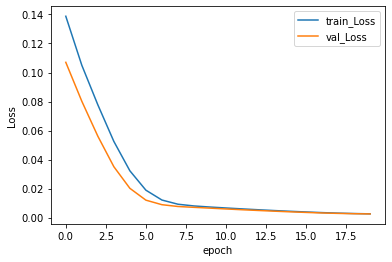

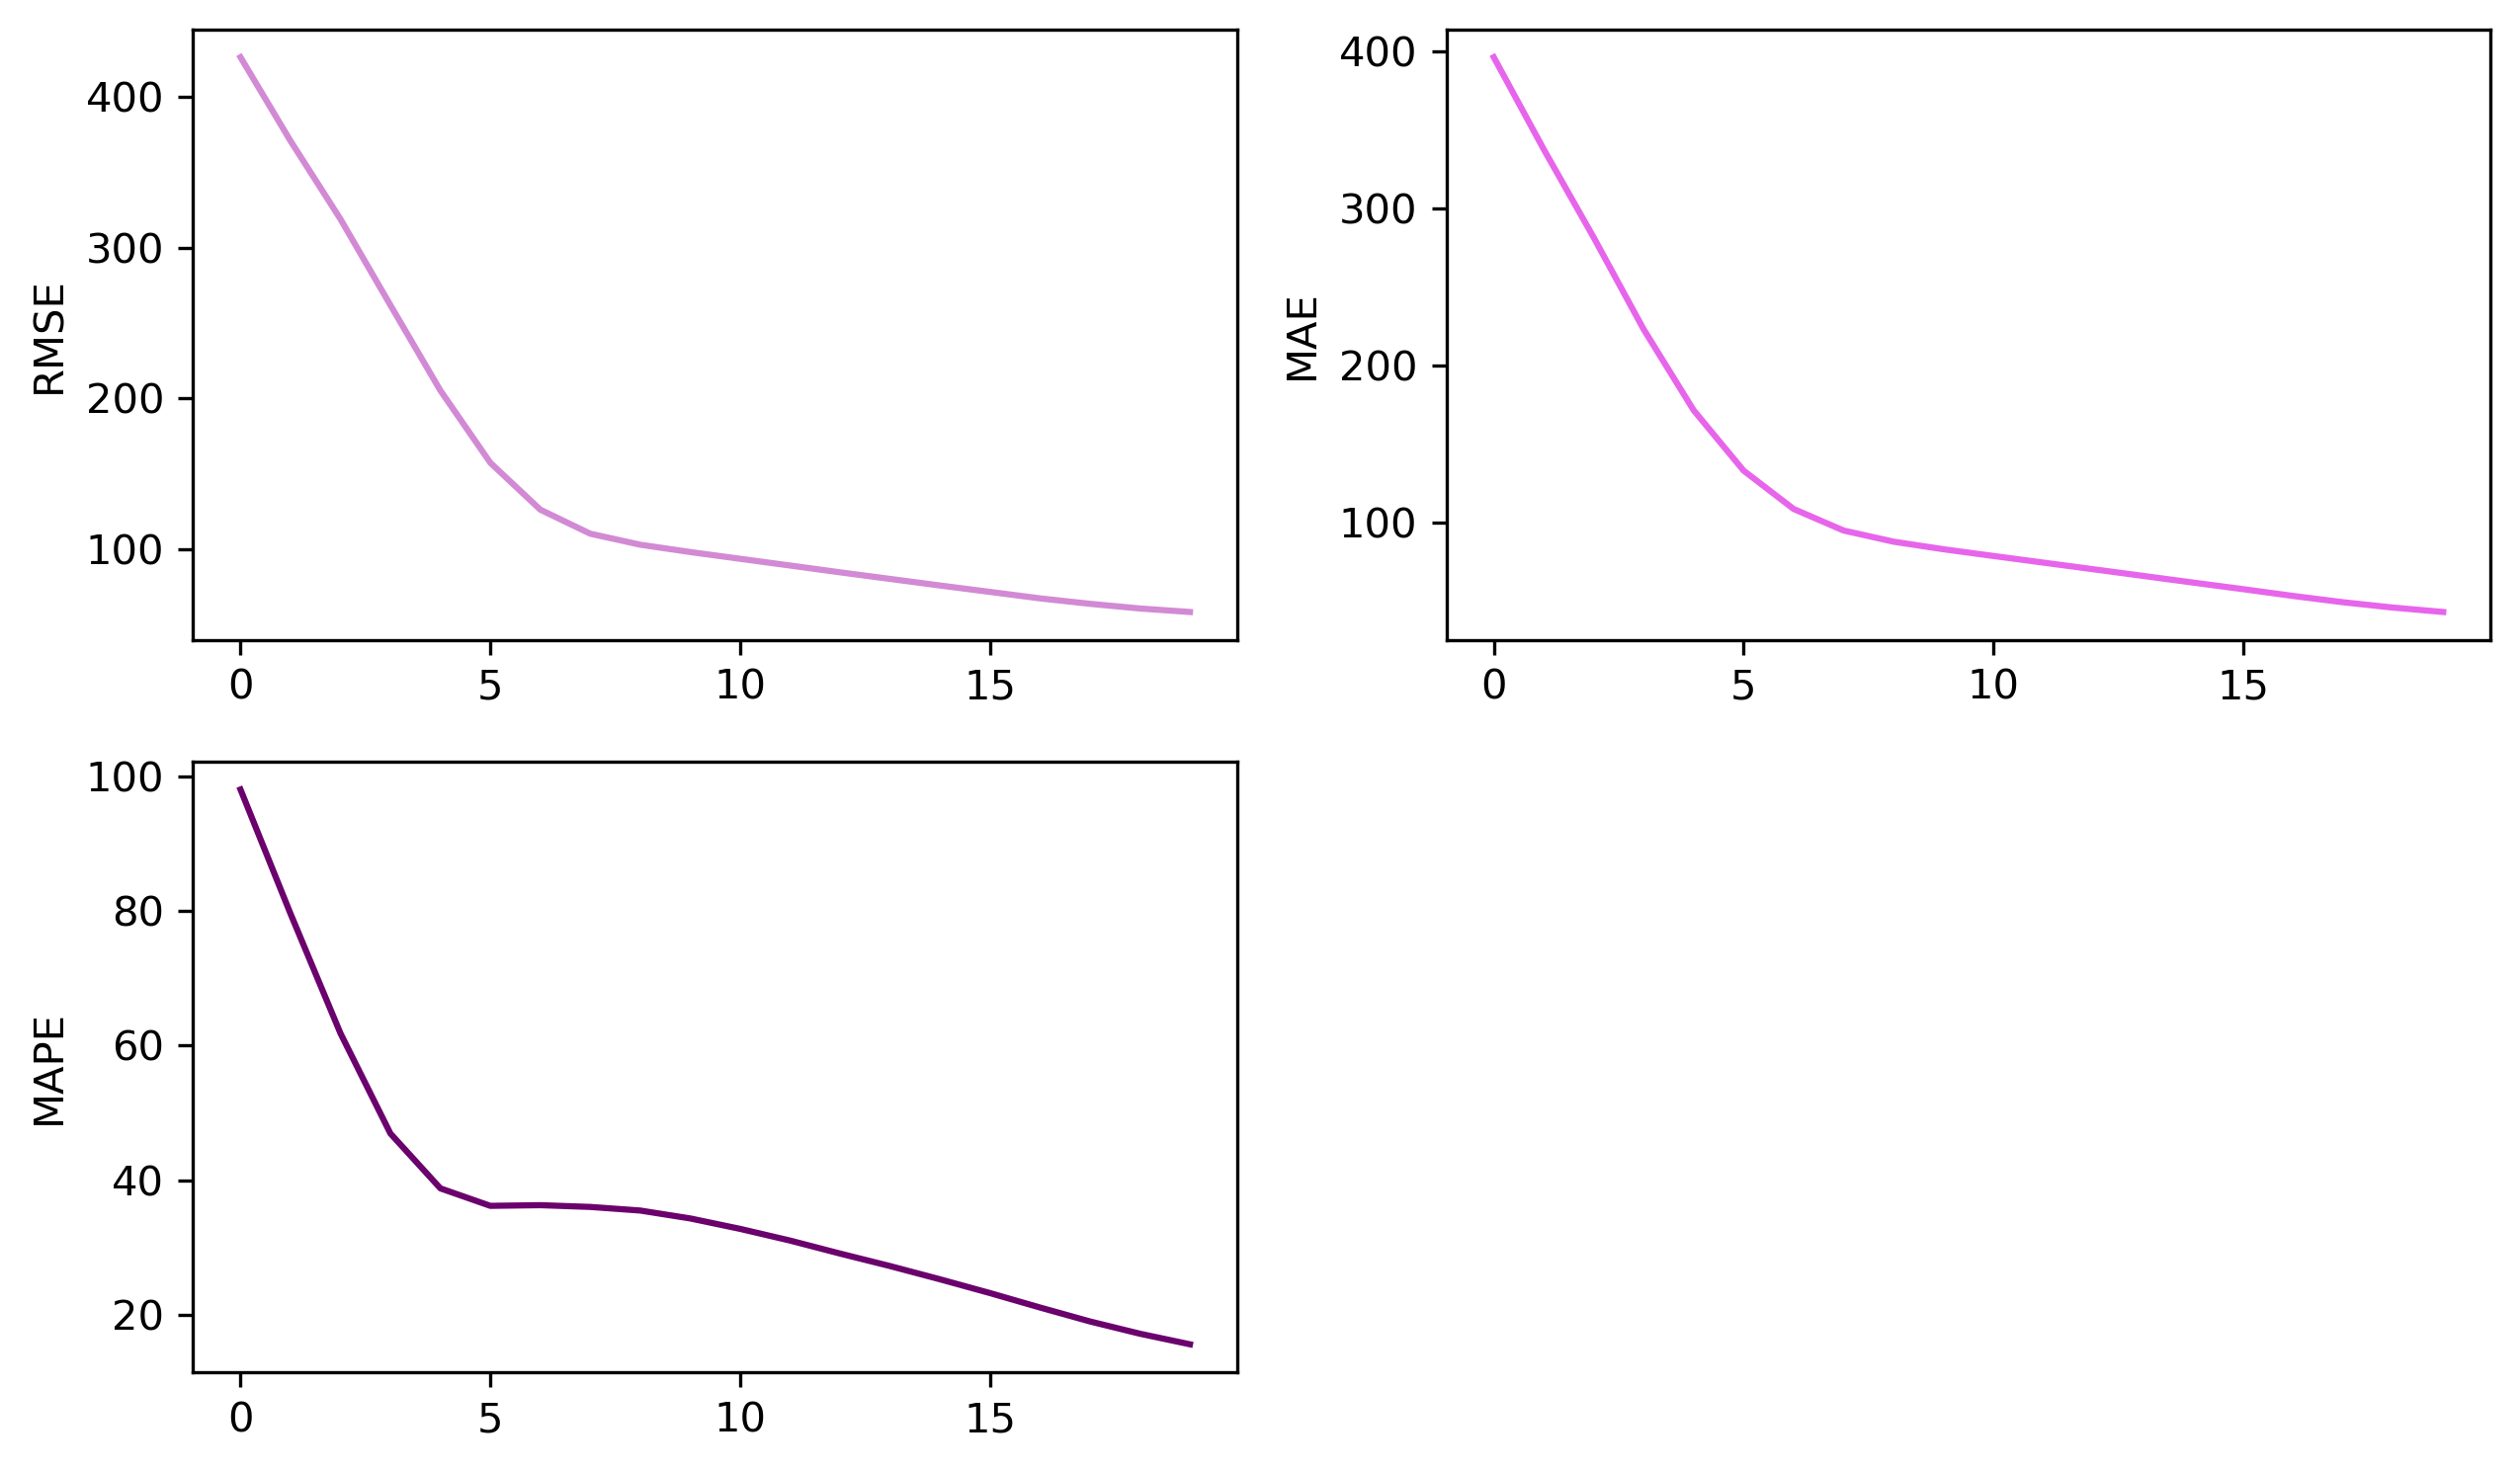

In [14]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)